# Neural Network

In [1]:
import torch
import torch.nn as nn
import wandb
import pandas as pd
import numpy as np
import shap
import json
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
# local
from analytics.gear_vibration.data_loader import load_data
from analytics.gear_vibration.models import NnClassifier
from analytics.gear_vibration.model_trainer import ModelTrainer
from analytics.gear_vibration.data_loader import GearVibrationLstmDataset
from analytics.gear_vibration.analysis import sliding_window_features, drop_features, normalize_features
from analytics.utils import log_metrics_mlflow

In [2]:
data, df = load_data(path=Path('./data/gear_vibration'))

In [3]:
VERSION = '0.0.1'
CONFIG = {'window_size': 256, 'step_size': 128, 'version': VERSION, 'normalized': True, 'batch_size': 128}
mlflow_expiriment = 'gear_vibration'
model_name = f'nn_w_{CONFIG["window_size"]}'

In [4]:
df_window, df_labels = sliding_window_features(df=df, window_size=CONFIG['window_size'], step_size=CONFIG['step_size'])
labels, fault_code = pd.factorize(df_labels['fault'])
df_window = drop_features(df=df_window, threshold=0.95)
df_window_norm = normalize_features(df=df_window)

Number of correlated features: 3
Correlated features: {'sensor2_ptp', 'sensor1_rms', 'sensor2_rms'}

Highly correlated feature pairs:
sensor1_rms and sensor1_mean: 1.00
sensor2_rms and sensor2_mean: 1.00
sensor2_ptp and sensor2_std: 0.96
Drop highly correlated features!


In [5]:
model = NnClassifier(input_dim=len(df_window_norm.columns), output_dim=len(fault_code), dropout=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
dataset = GearVibrationLstmDataset(features=df_window_norm, labels=labels)
train, validate = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train, batch_size=CONFIG['batch_size'], shuffle=False)
validate_loader = DataLoader(validate, batch_size=CONFIG['batch_size'], shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
num_epochs = 200
scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
summary(model, input_size=(CONFIG['batch_size'], len(df_window_norm.columns)))

Using device: cuda


Layer (type:depth-idx)                   Output Shape              Param #
NnClassifier                             [128, 6]                  --
├─Sequential: 1-1                        [128, 6]                  --
│    └─Linear: 2-1                       [128, 128]                4,096
│    └─ReLU: 2-2                         [128, 128]                --
│    └─Dropout: 2-3                      [128, 128]                --
│    └─Linear: 2-4                       [128, 128]                16,512
│    └─ReLU: 2-5                         [128, 128]                --
│    └─Dropout: 2-6                      [128, 128]                --
│    └─Linear: 2-7                       [128, 64]                 8,256
│    └─ReLU: 2-8                         [128, 64]                 --
│    └─Dropout: 2-9                      [128, 64]                 --
│    └─Linear: 2-10                      [128, 6]                  390
Total params: 29,254
Trainable params: 29,254
Non-trainable params: 0
Tota

In [6]:
trainer = ModelTrainer(
  model=model,
  model_name=model_name,
  criterion=criterion,
  optimizer=optimizer,
  train_loader=train_loader,
  val_loader=validate_loader,
  num_epochs=num_epochs,
  device=device,
  scheduler=scheduler,
  version=VERSION,
  config=CONFIG,
  mlflow_expiriment=mlflow_expiriment,
  mlflow_url='http://localhost:5011',
)
label = {idx: fault[0] for idx, fault in enumerate(fault_code)}
tags = {'analysis': mlflow_expiriment, 'labels': json.dumps(label)} 

In [7]:
trainer.train(tags=tags)

Epoch [1/200], Training Loss: 1.5609, Validation Loss: 1.2286, Training Accuracy: 36.36%, Validation Accuracy: 47.86%
Epoch [2/200], Training Loss: 1.0885, Validation Loss: 0.9225, Training Accuracy: 53.28%, Validation Accuracy: 60.40%
Epoch [3/200], Training Loss: 0.8832, Validation Loss: 0.7295, Training Accuracy: 63.82%, Validation Accuracy: 71.65%
Epoch [4/200], Training Loss: 0.7150, Validation Loss: 0.5603, Training Accuracy: 71.69%, Validation Accuracy: 79.49%
Epoch [5/200], Training Loss: 0.5960, Validation Loss: 0.4439, Training Accuracy: 77.37%, Validation Accuracy: 84.47%
Epoch [6/200], Training Loss: 0.5049, Validation Loss: 0.3509, Training Accuracy: 80.89%, Validation Accuracy: 87.61%
Epoch [7/200], Training Loss: 0.4372, Validation Loss: 0.2936, Training Accuracy: 83.32%, Validation Accuracy: 90.10%
Epoch [8/200], Training Loss: 0.4003, Validation Loss: 0.2599, Training Accuracy: 85.13%, Validation Accuracy: 91.45%
Epoch [9/200], Training Loss: 0.3473, Validation Loss: 0

2025/05/27 16:15:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch [157/200], Training Loss: 0.0732, Validation Loss: 0.0672, Training Accuracy: 97.76%, Validation Accuracy: 97.72%
Early stopping at epoch 157


2025/05/27 16:15:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
Successfully registered model 'nn_w_256'.
2025/05/27 16:15:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nn_w_256, version 1
Created version '1' of model 'nn_w_256'.
Registered model 'nn_w_256' already exists. Creating a new version of this model...
2025/05/27 16:15:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: nn_w_256, version 2


🏃 View run nn_w_256 at: http://localhost:5011/#/experiments/2/runs/9150a1be8f3646928005ff6929c36536
🧪 View experiment at: http://localhost:5011/#/experiments/2


Created version '2' of model 'nn_w_256'.


NnClassifier(
  (model): Sequential(
    (0): Linear(in_features=31, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=6, bias=True)
  )
)

🏃 View run nn_w_256 at: http://localhost:5011/#/experiments/2/runs/9150a1be8f3646928005ff6929c36536
🧪 View experiment at: http://localhost:5011/#/experiments/2
accuracy: 0.9772
precision_macro: 0.9774
recall_macro: 0.9773
f1_macro: 0.9774
precision_weighted: 0.9774
recall_weighted: 0.9772
f1_weighted: 0.9773


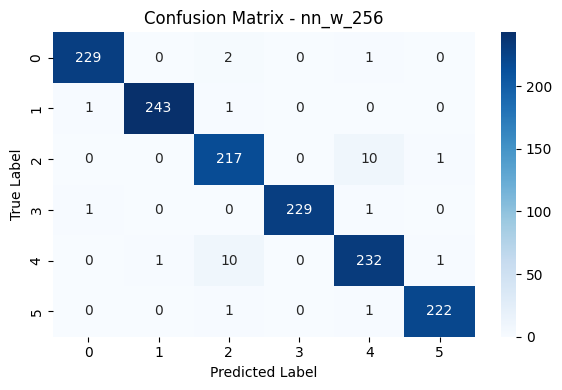

In [8]:
model.eval()
all_preds = []
all_labels = []
for X_batch, y_batch in validate_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    model = model.to(device)
    outputs = model(X_batch)
    preds = torch.argmax(outputs, dim=1)
    all_preds.append(preds.cpu().numpy())
    all_labels.append(y_batch.cpu().numpy())
y_pred = np.concatenate(all_preds)
y_test = np.concatenate(all_labels)
metrics = log_metrics_mlflow(y_test, y_pred, model_name=model_name, run_id=trainer.get_tmp_run_id())
for k, v in metrics.items():
    print(f'{k}: {v:.4f}')

<Figure size 640x480 with 0 Axes>

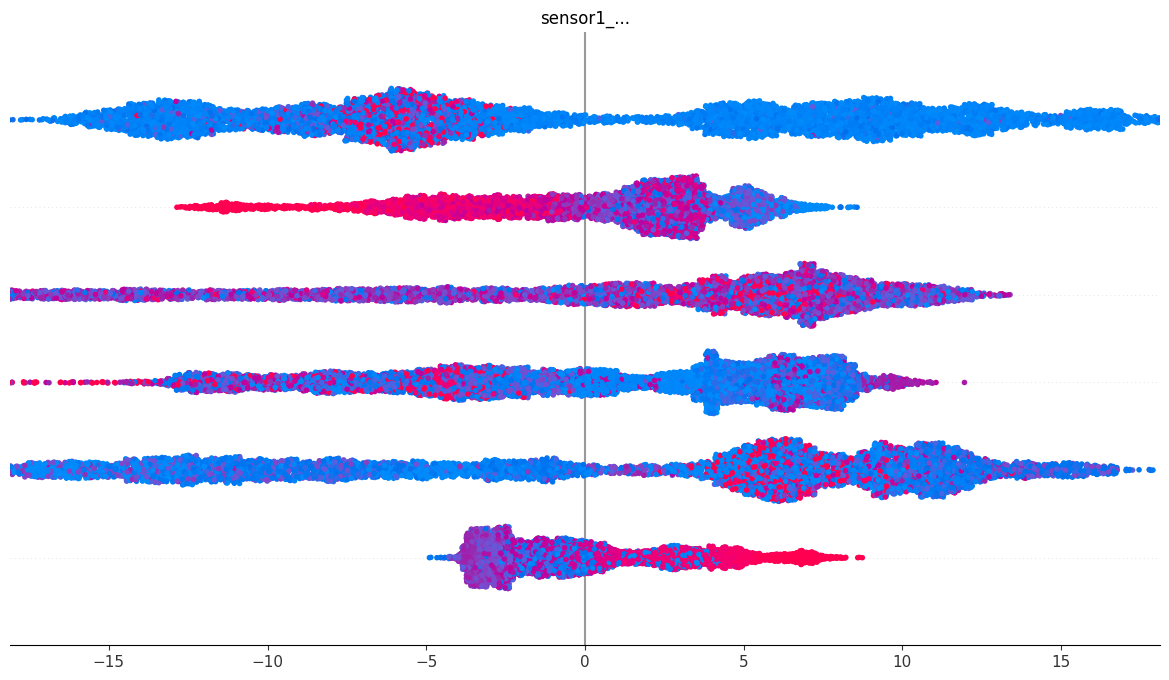

In [9]:
model.eval()
background = torch.tensor(df_window_norm.sample(100, random_state=42).to_numpy(), dtype=torch.float32).to(device)
explainer = shap.DeepExplainer(model, background)
test_data = torch.tensor(df_window_norm.to_numpy(), dtype=torch.float32).to(device)
shap_values = explainer.shap_values(test_data)
shap.summary_plot(shap_values, df_window_norm, feature_names=df_window_norm.columns)